# Malaysian Sign Language (MSL) Classification: Model Comparison

Comparing different model architectures for Malaysian Sign Language (MSL) classification using the `uniform_30` preprocessing strategy.

## 1. Introduction

After determining that **uniform sampling of 30 frames (`uniform_30`)** yields better performance, this notebook compares three PyTorch-based temporal models:

1. **Baseline LSTM**
2. **Improved LSTM with Attention**
3. **Transformer Encoder**

All models are trained and evaluated using the **same data split**, **same training pipeline**, and **same evaluation metrics**, ensuring a fair comparison.


## 2. Setup & Reproducibility

In [42]:
import os
import random
import json
from pathlib import Path

# Evaluation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset


def set_seed(seed: int):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [43]:
DATA_DIR = Path(os.getcwd()).parent / "data/BIM Dataset V3"
CKPT_DIR = Path(os.getcwd()).parent / "weights"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

## 3. Load `uniform_30` Tensors

In [44]:
TENSOR_ROOT = DATA_DIR / "tensors/uniform_30"

X_train = np.load(TENSOR_ROOT / "X_train.npy")
y_train = np.load(TENSOR_ROOT / "y_train.npy")
X_test = np.load(TENSOR_ROOT / "X_test.npy")
y_test = np.load(TENSOR_ROOT / "y_test.npy")

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2919, 30, 258) (2919,)
(325, 30, 258) (325,)


## 4. DataLoader Preparation

In [45]:
batch_size = 32

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t),
    batch_size=batch_size,
    shuffle=False,
)


## 5. Training & Evaluation Pipeline

In [46]:
def train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=100,
    gradient_clip=False,
    ckpt_path=None,
    min_delta=1e-4,
    patience=15,
):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(epochs):
        # =====================
        # Training
        # =====================
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()

            if gradient_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            correct += (outputs.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # =====================
        # Validation
        # =====================
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for xb, yb in test_loader:
                outputs = model(xb)
                loss = criterion(outputs, yb)

                val_loss_sum += loss.item() * xb.size(0)
                val_correct += (outputs.argmax(1) == yb).sum().item()
                val_total += yb.size(0)

        val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # =====================
        # Checkpoint logic
        # =====================
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0

            if ckpt_path is not None:
                torch.save(model.state_dict(), ckpt_path)
        else:
            epochs_no_improve += 1

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch + 1}/{epochs}] "
                f"Train Loss: {train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | "
                f"Train Acc: {train_acc:.4f} | "
                f"Val Acc: {val_acc:.4f}"
            )

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_losses, val_losses, train_accs, val_accs


In [47]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    preds, labels = [], []
    loss_sum, total = 0.0, 0

    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)

            loss_sum += loss.item() * xb.size(0)
            total += yb.size(0)

            preds.append(outputs.argmax(1).cpu().numpy())
            labels.append(yb.cpu().numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)

    acc = (preds == labels).mean()
    avg_loss = loss_sum / total

    return avg_loss, acc, preds, labels


## 6. Model Definitions

### 6.1. Baseline LSTM

In [48]:
class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

### 6.2. Improved LSTM (BiLSTM + Attention)

- Bidirectional → captures past & future context
- Attention → focuses on important frames
- Dropout → better generalization


In [49]:
class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (B, T, H)
        weights = torch.softmax(self.attn(x), dim=1)
        print(weights.shape)
        return (weights * x).sum(dim=1)


class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3,
        )
        self.attn = TemporalAttention(hidden_size * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        print(x.shape)
        x = self.attn(x)
        return self.fc(x)


### 6.3. Transformer Encoder

In [50]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes, d_model=128, nhead=4, num_layers=2):
        super().__init__()

        self.input_proj = nn.Linear(input_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        x = x.mean(dim=1)  # global average pooling
        return self.fc(x)


In [51]:
baseline = BaselineLSTM(
    input_size=X_train.shape[2],
    hidden_size=128,
    num_classes=len(np.unique(y_train)),
)
bilstm = BiLSTMWithAttention(
    input_size=X_train.shape[2],
    hidden_size=128,
    num_classes=len(np.unique(y_train)),
)
trans = TransformerModel(
    input_size=X_train.shape[2], num_classes=len(np.unique(y_train))
)

baseline_count = sum(p.numel() for p in baseline.parameters())
bilistm_count = sum(p.numel() for p in bilstm.parameters())
trans_count = sum(p.numel() for p in trans.parameters())

In [52]:
print(baseline_count, bilistm_count, trans_count)

491806 829599 301982


## 7. Run Experiments: Training & Evaluation

In [53]:
models = {
    "Baseline LSTM": BaselineLSTM(X_train.shape[-1], 64, len(np.unique(y_train))),
    "BiLSTM + Attention": BiLSTMWithAttention(
        X_train.shape[-1], 64, len(np.unique(y_train))
    ),
    "Transformer": TransformerModel(X_train.shape[-1], len(np.unique(y_train))),
}

results = {}


In [54]:
for name, model in models.items():
    print(f"\n{'=' * 60}")
    print(f"Training {name}")
    print(f"{'=' * 60}")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    ckpt_path = CKPT_DIR / f"{model._get_name().lower()}_best.pth"

    train_l, val_l, train_a, val_a = train_model(
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        epochs=100,
        gradient_clip=True,
        ckpt_path=ckpt_path,
        min_delta=1e-4,
        patience=20,
    )

    # Load best checkpoint
    model.load_state_dict(torch.load(ckpt_path))

    test_loss, test_acc, preds, labels = evaluate_model(
        model,
        test_loader,
        criterion,
    )

    results[name] = {
        "model": model,
        "train_losses": train_l,
        "val_losses": val_l,
        "train_accs": train_a,
        "val_accs": val_a,
        "test_loss": test_loss,
        "test_accuracy": test_acc,
        "y_pred": preds,
        "y_true": labels,
    }

    print(f"{name} — Test Accuracy: {test_acc:.4f}")



Training Baseline LSTM
Epoch [10/100] Train Loss: 2.0401 | Val Loss: 2.0243 | Train Acc: 0.2871 | Val Acc: 0.3262
Epoch [20/100] Train Loss: 1.5815 | Val Loss: 1.5852 | Train Acc: 0.4293 | Val Acc: 0.4338
Epoch [30/100] Train Loss: 1.1585 | Val Loss: 1.2277 | Train Acc: 0.5944 | Val Acc: 0.6123
Epoch [40/100] Train Loss: 0.8259 | Val Loss: 0.9499 | Train Acc: 0.6982 | Val Acc: 0.6862
Epoch [50/100] Train Loss: 0.6790 | Val Loss: 1.1246 | Train Acc: 0.7616 | Val Acc: 0.6923
Epoch [60/100] Train Loss: 0.5746 | Val Loss: 0.7276 | Train Acc: 0.8051 | Val Acc: 0.7723
Epoch [70/100] Train Loss: 0.3691 | Val Loss: 0.8443 | Train Acc: 0.8794 | Val Acc: 0.7846
Epoch [80/100] Train Loss: 0.3352 | Val Loss: 1.2122 | Train Acc: 0.9000 | Val Acc: 0.8092
Early stopping at epoch 83
Baseline LSTM — Test Accuracy: 0.8308

Training BiLSTM + Attention
torch.Size([32, 30, 128])
torch.Size([32, 30, 1])
torch.Size([32, 30, 128])
torch.Size([32, 30, 1])
torch.Size([32, 30, 128])
torch.Size([32, 30, 1])
torc

## 8. Learning Curves & Results Comparison

In [55]:
def plot_loss_and_accuracy(
    train_losses, val_losses, train_accs, val_accs, title_prefix=""
):
    """
    Plot training & validation loss and accuracy side-by-side.

    Parameters
    ----------
    train_losses : list[float]
        Training loss per epoch
    val_losses : list[float]
        Validation loss per epoch
    train_accs : list[float]
        Training accuracy per epoch
    val_accs : list[float]
        Validation accuracy per epoch
    title_prefix : str
        Prefix for plot titles (e.g. 'first_30', 'uniform_30')
    """

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # -----------------------
    # Loss curves
    # -----------------------
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(val_losses, label="Validation Loss")
    axes[0].set_title(f"{title_prefix} Loss Curves")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # -----------------------
    # Accuracy curves
    # -----------------------
    axes[1].plot(train_accs, label="Train Accuracy")
    axes[1].plot(val_accs, label="Validation Accuracy")
    axes[1].set_title(f"{title_prefix}: Accuracy Curves")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

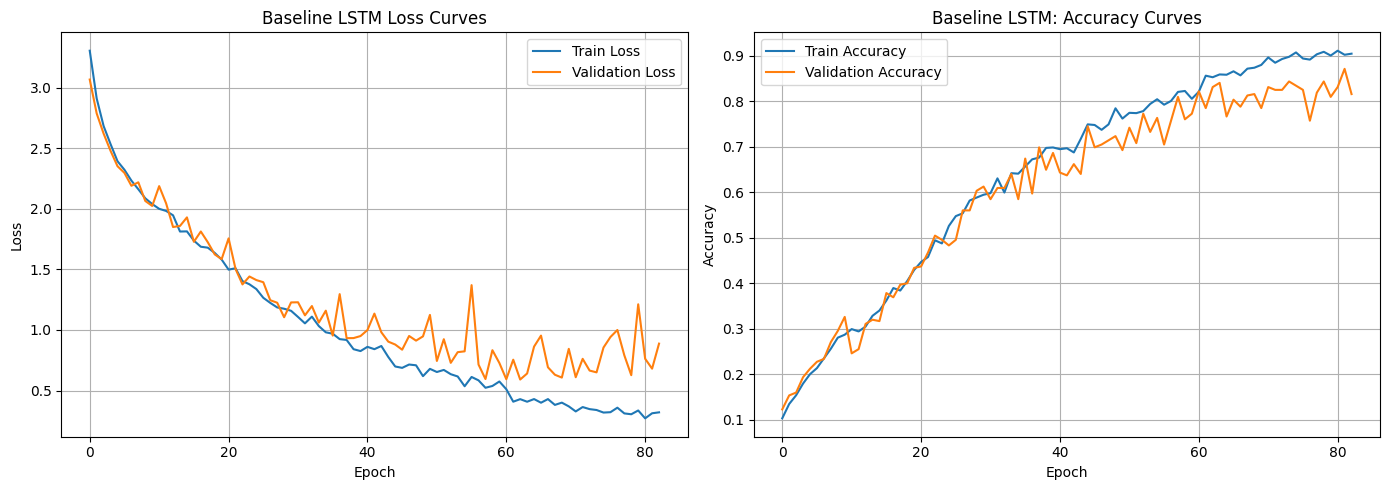

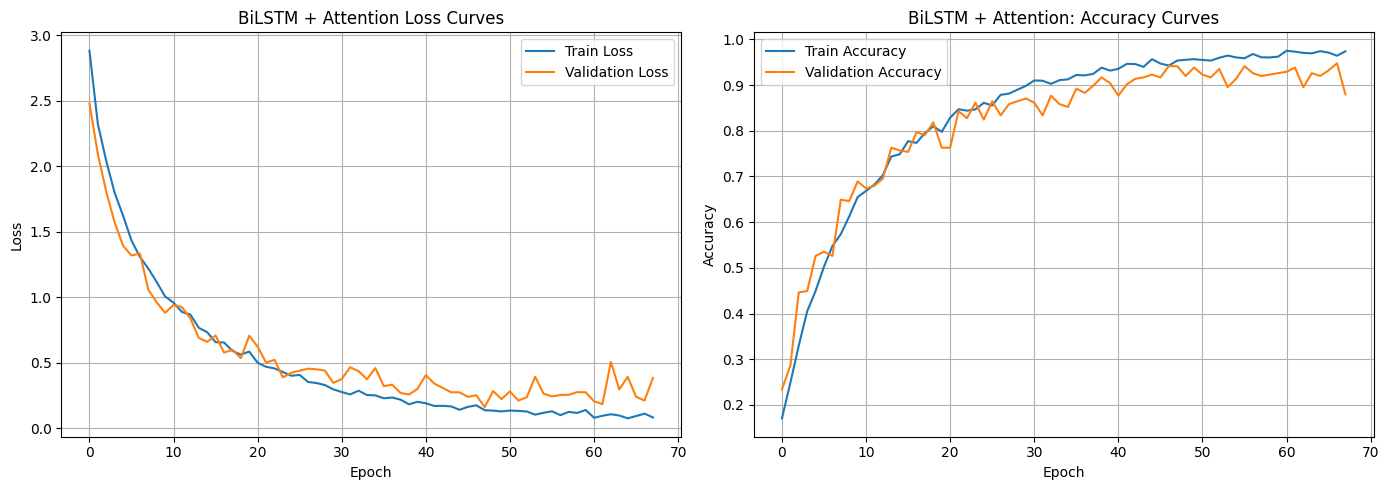

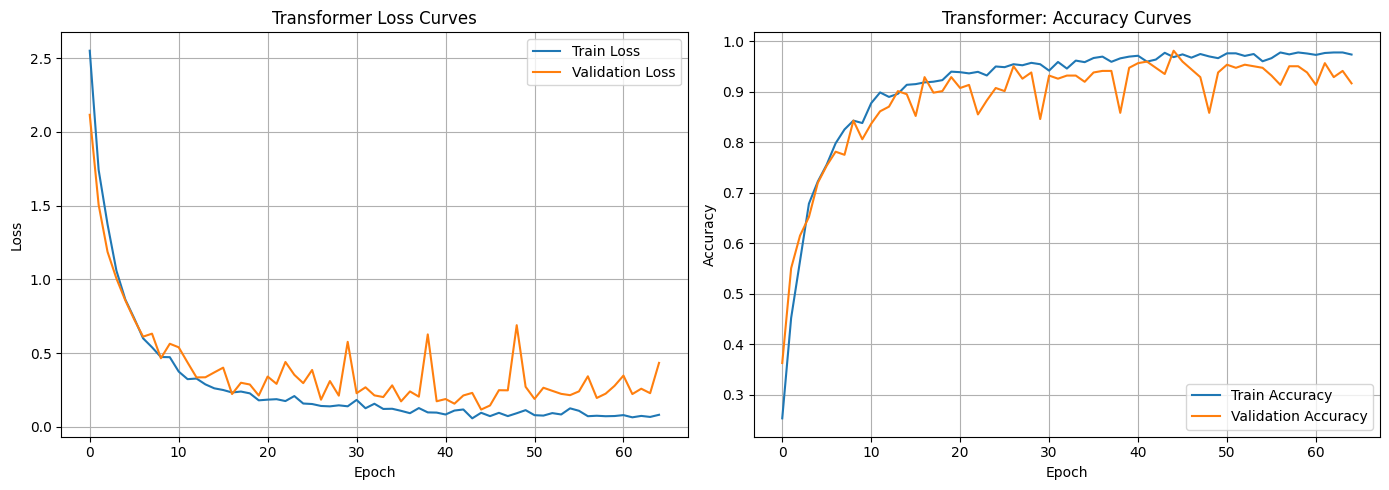

In [56]:
plot_loss_and_accuracy(
    results["Baseline LSTM"]["train_losses"],
    results["Baseline LSTM"]["val_losses"],
    results["Baseline LSTM"]["train_accs"],
    results["Baseline LSTM"]["val_accs"],
    title_prefix="Baseline LSTM",
)
plot_loss_and_accuracy(
    results["BiLSTM + Attention"]["train_losses"],
    results["BiLSTM + Attention"]["val_losses"],
    results["BiLSTM + Attention"]["train_accs"],
    results["BiLSTM + Attention"]["val_accs"],
    title_prefix="BiLSTM + Attention",
)
plot_loss_and_accuracy(
    results["Transformer"]["train_losses"],
    results["Transformer"]["val_losses"],
    results["Transformer"]["train_accs"],
    results["Transformer"]["val_accs"],
    title_prefix="Transformer",
)


Baseline LSTM: 83
BiLSTM + Attention: 68
Transformer: 65


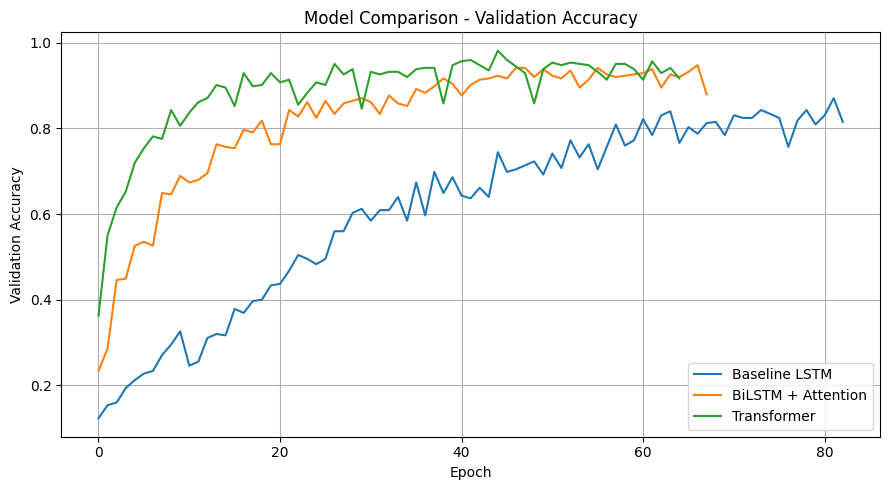

In [64]:
plt.figure(figsize=(9, 5))
for name, r in results.items():
    print(f"{name}: {len(r["val_accs"])}")
    plt.plot(r["val_accs"], label=name)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison - Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


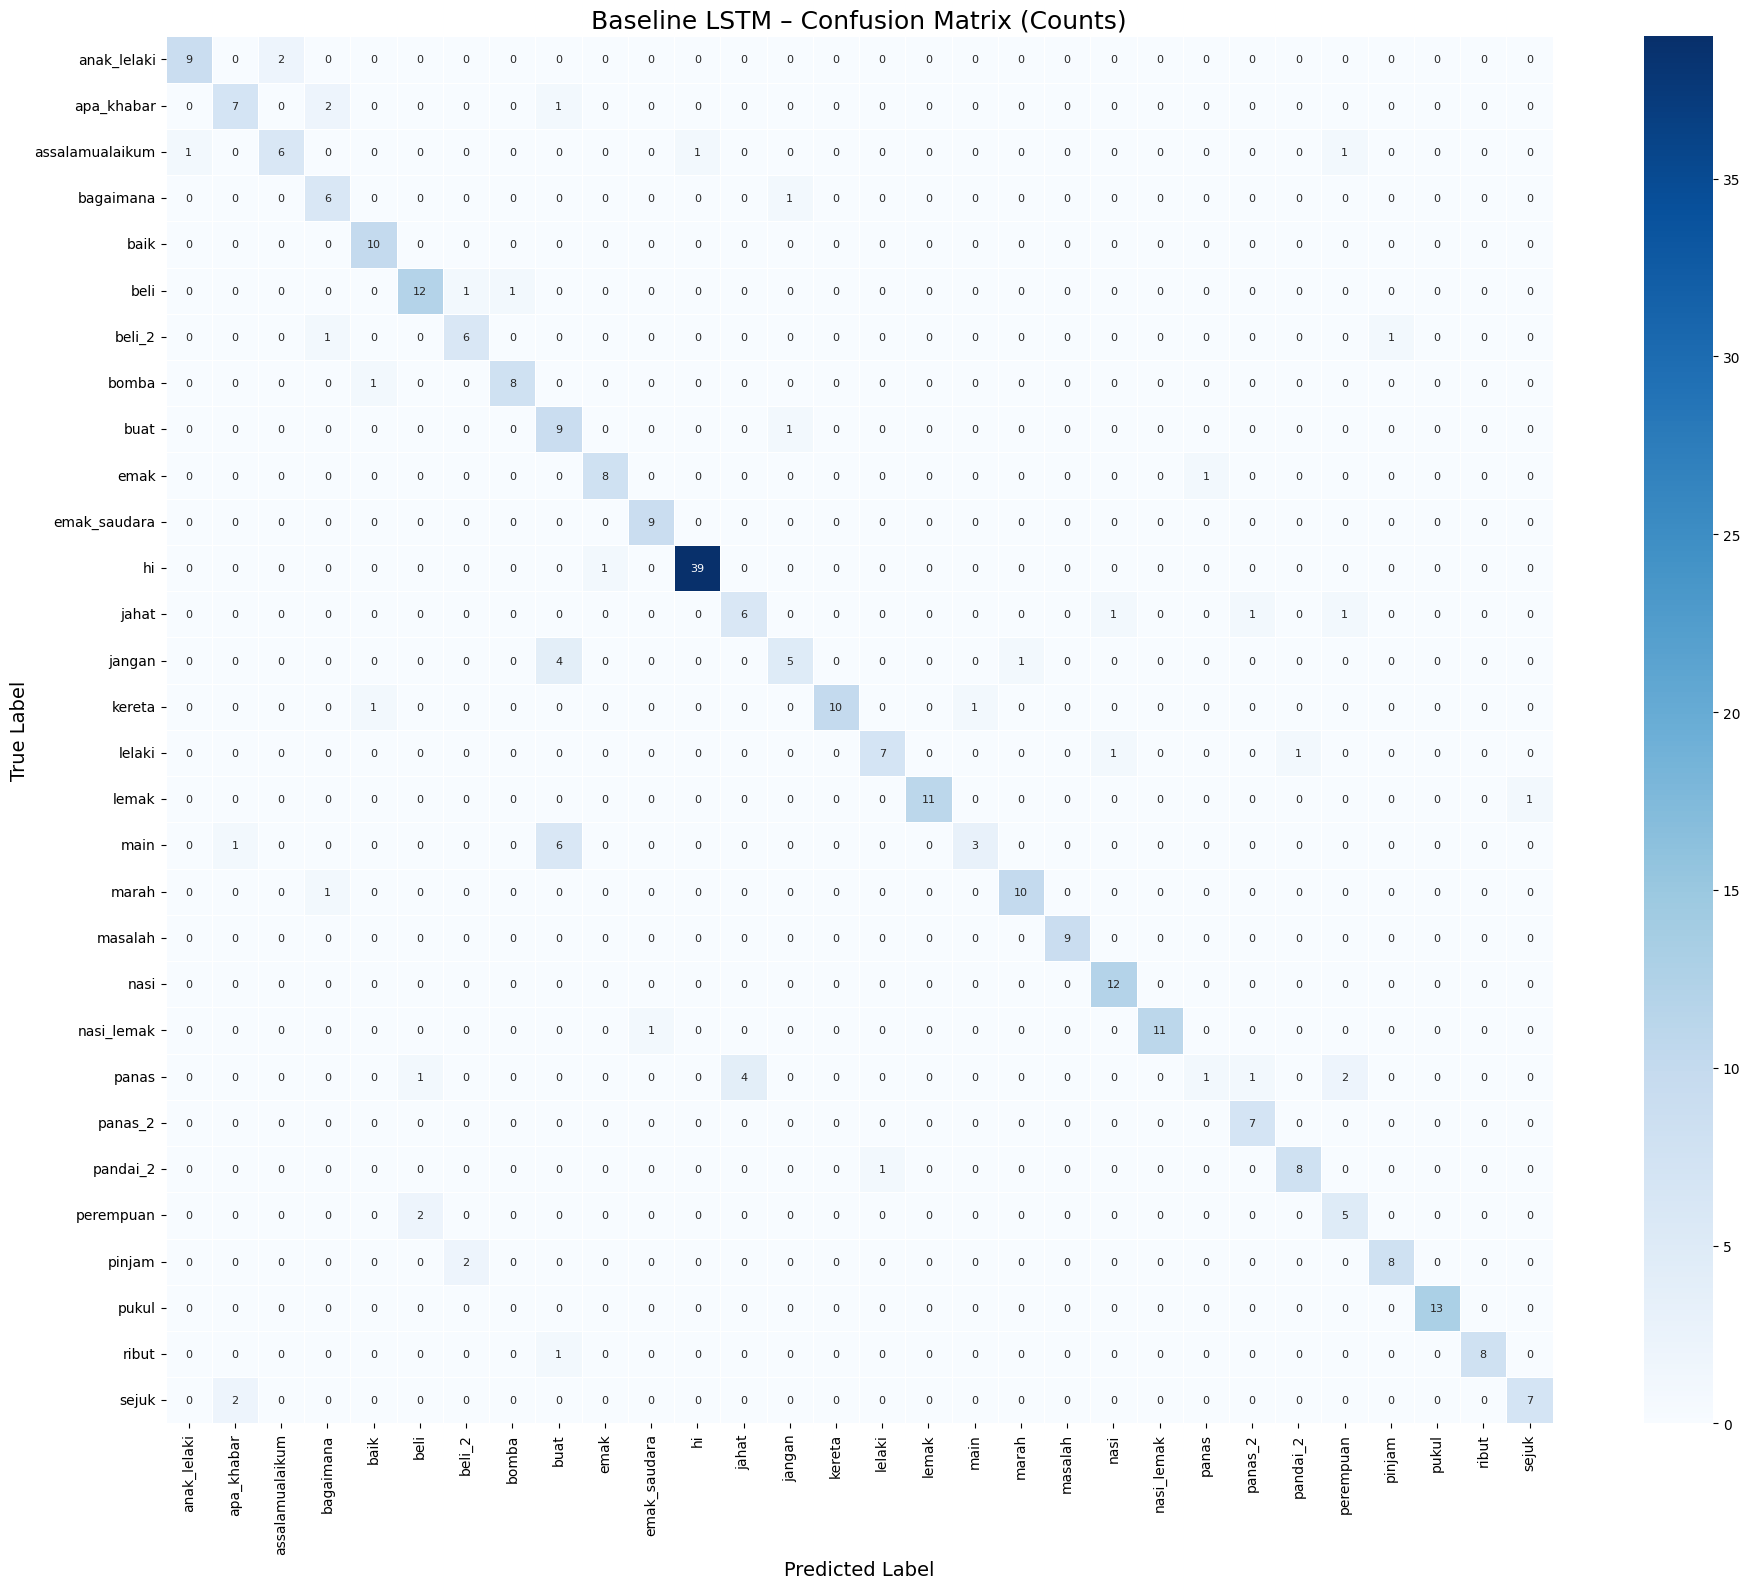

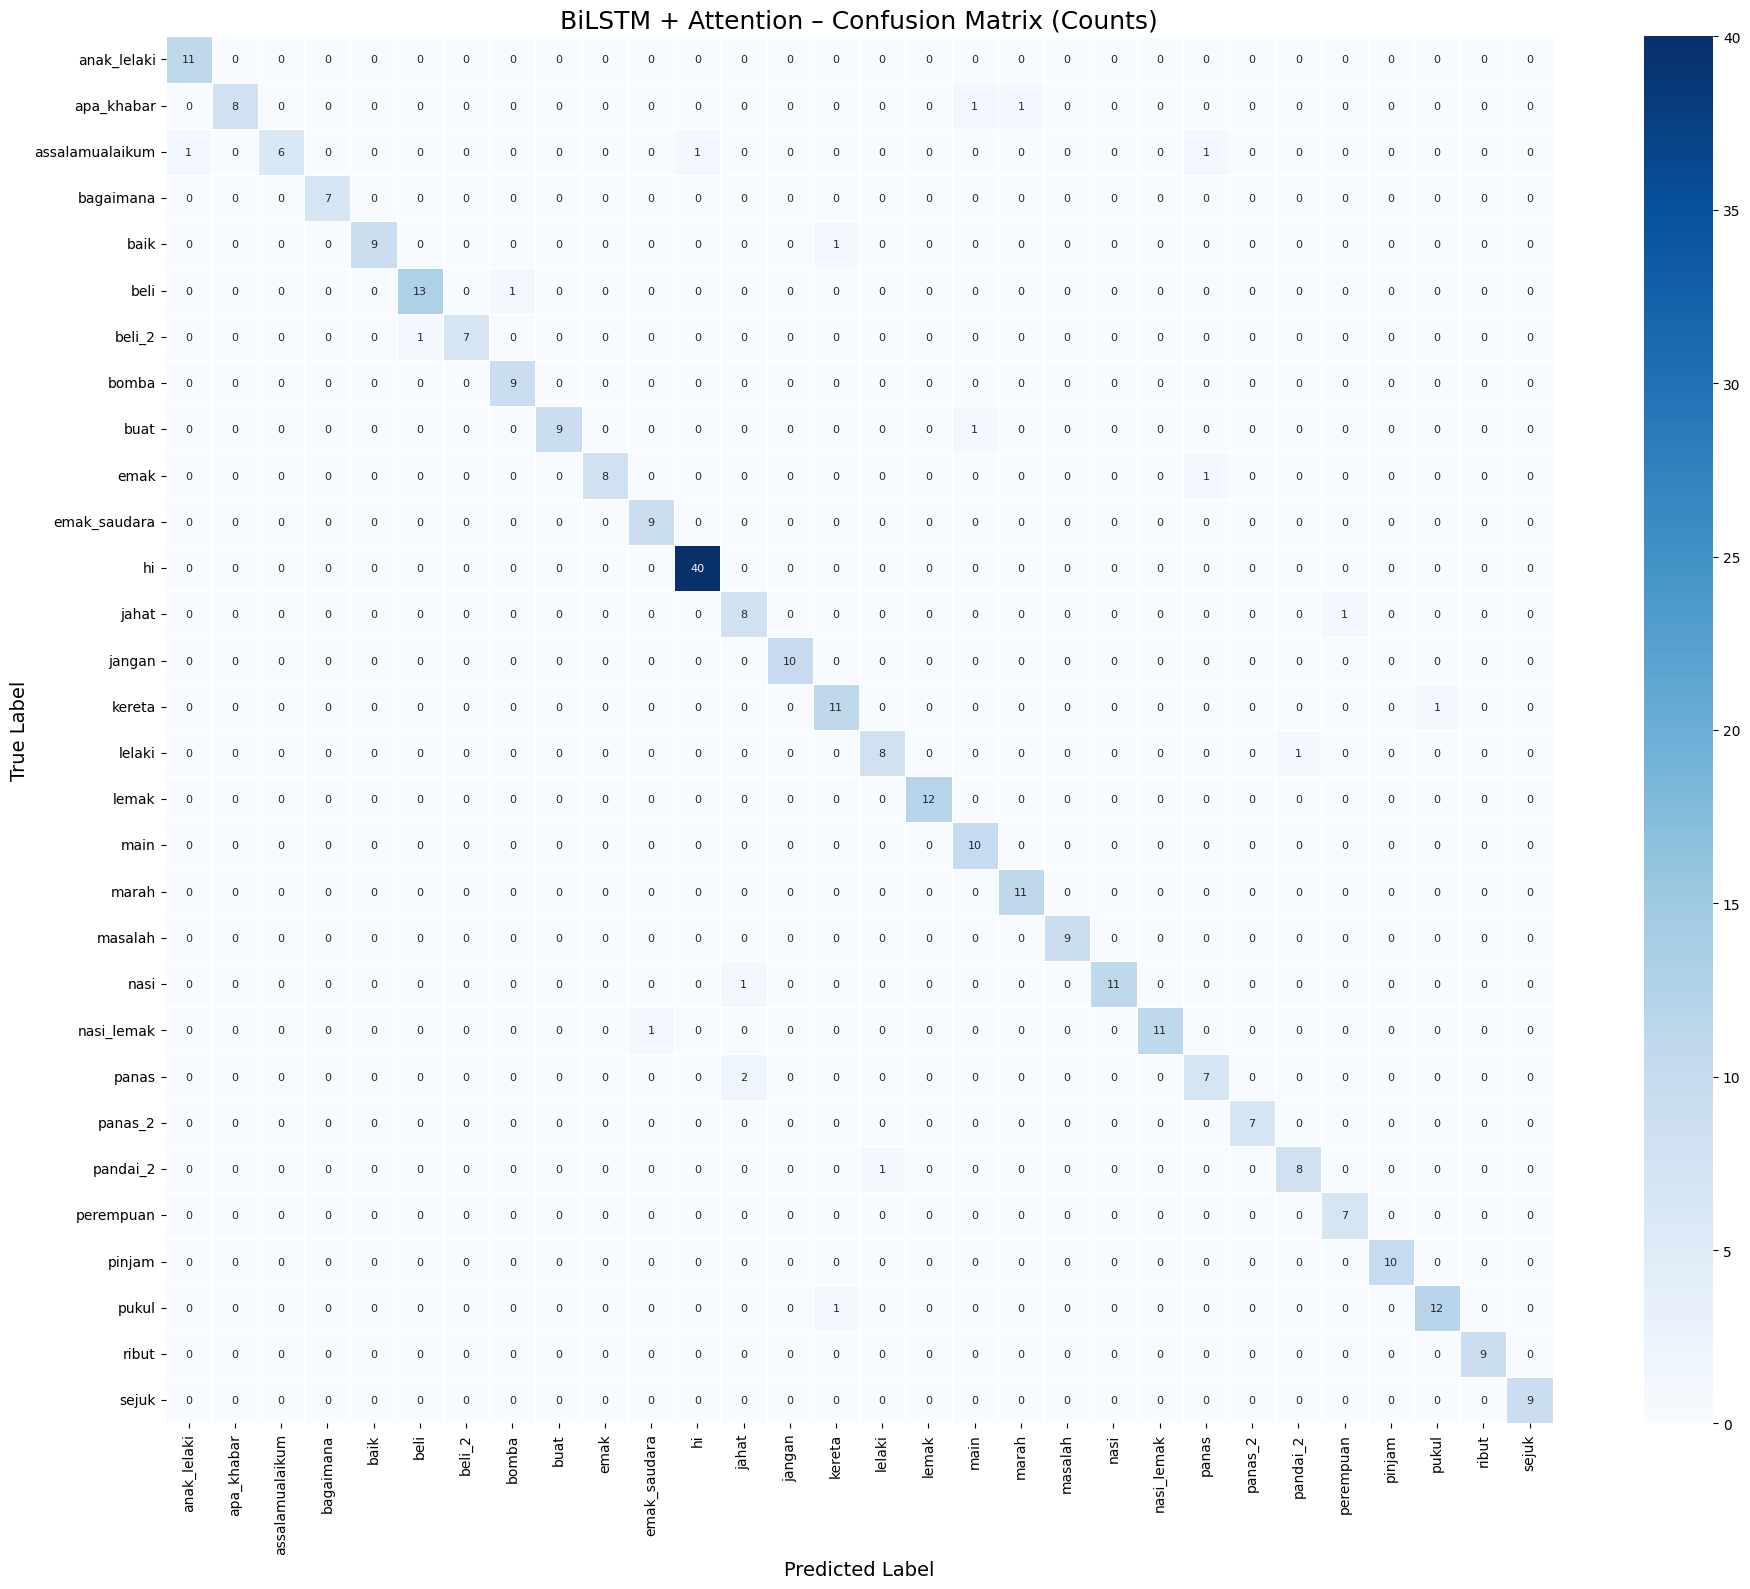

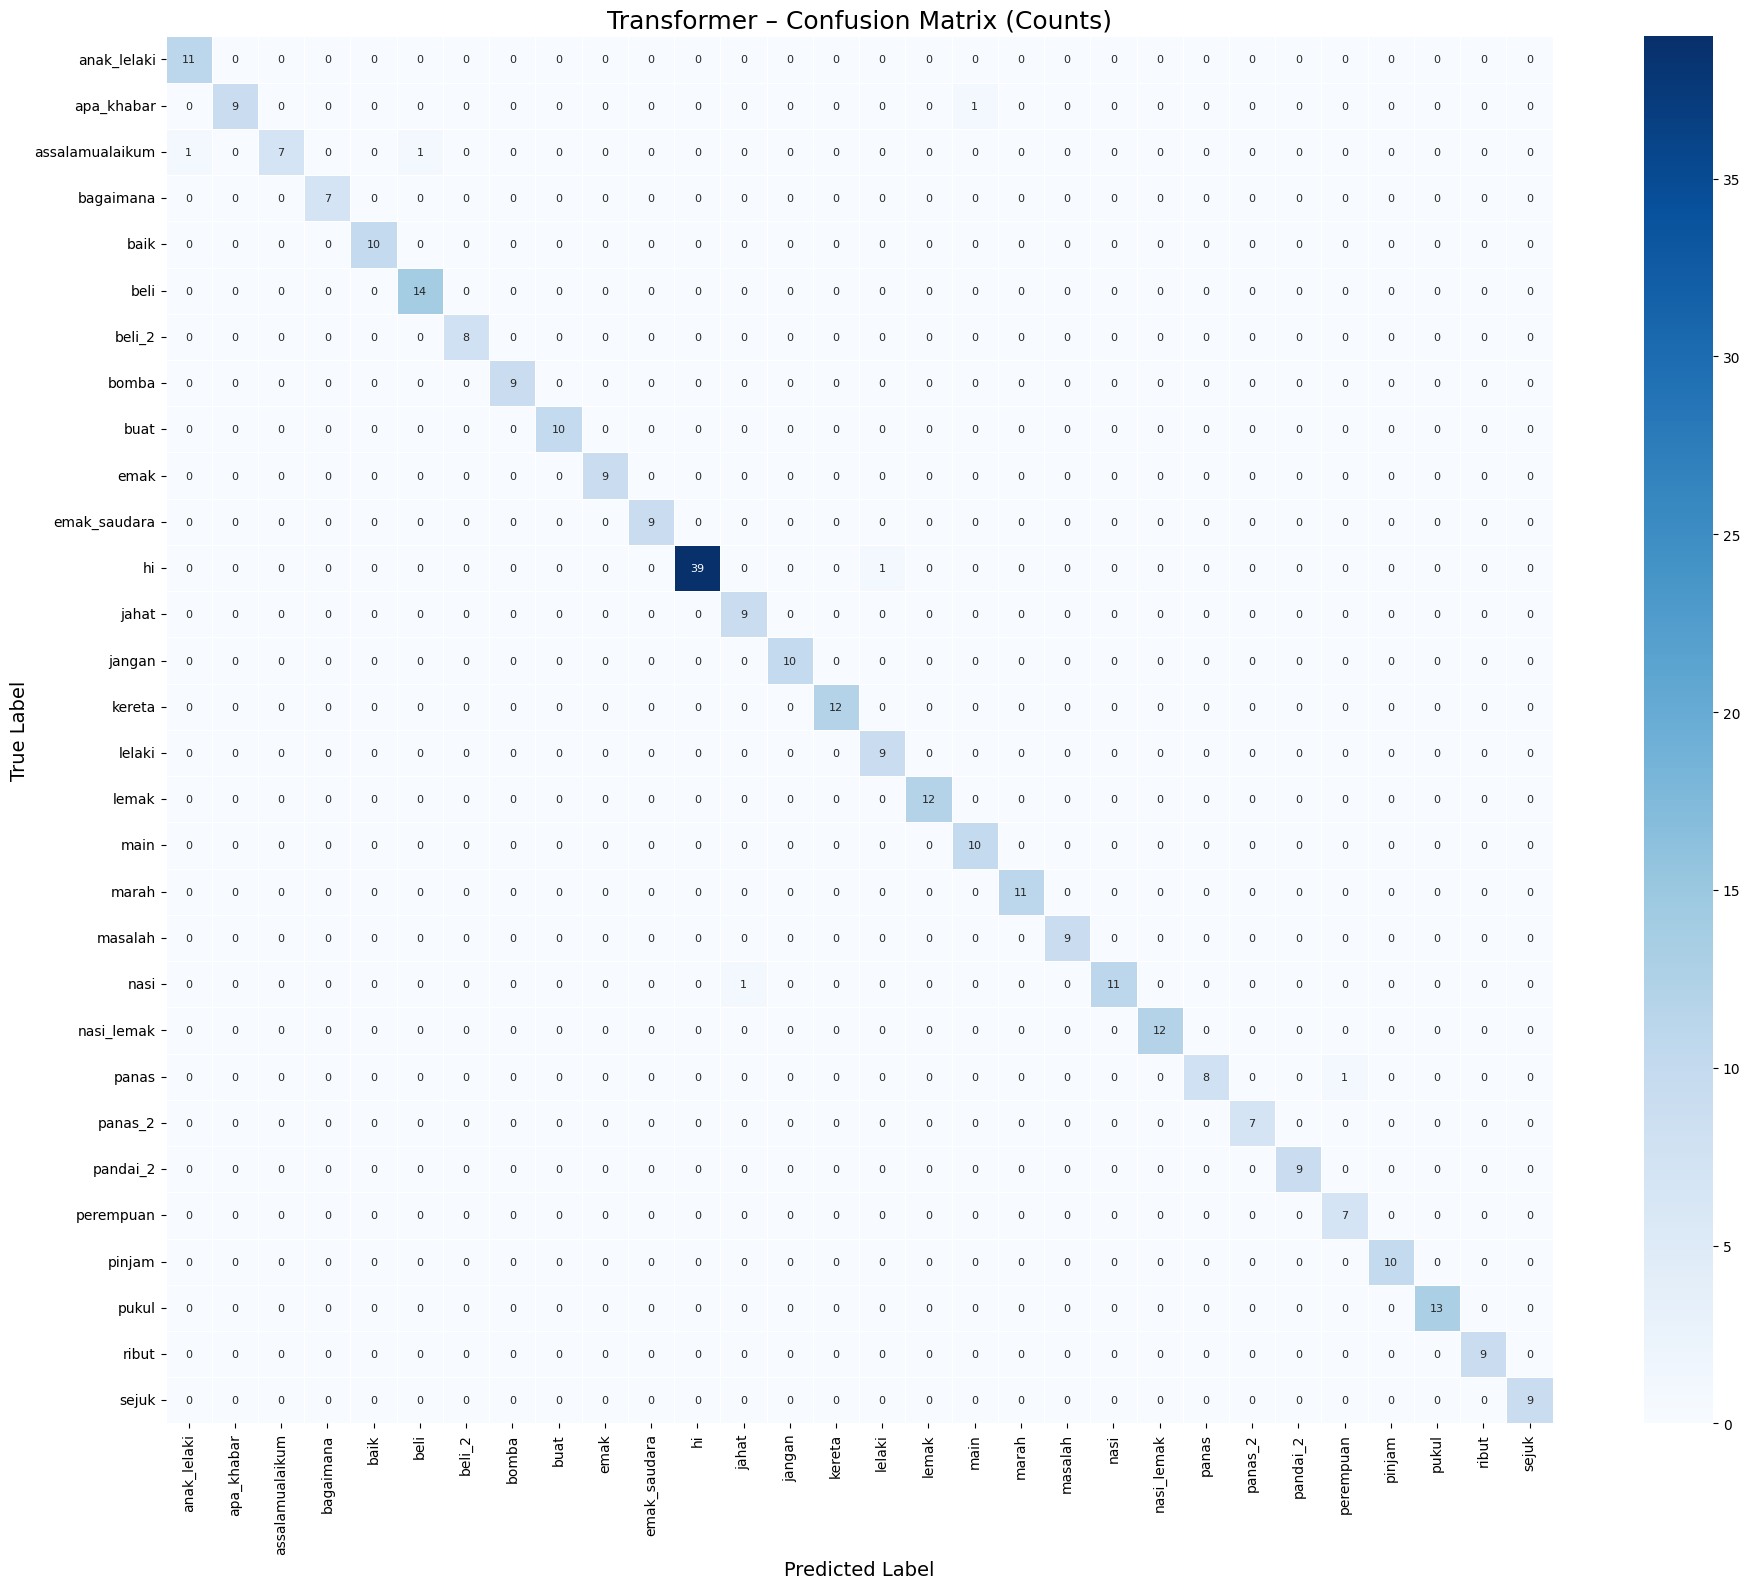

In [58]:
label_map = json.load(open(TENSOR_ROOT / "label_map.json"))
idx_to_label = {v: k for k, v in label_map.items()}
labels = [idx_to_label[i] for i in range(len(idx_to_label))]


for name, r in results.items():
    conf = confusion_matrix(r["y_true"], r["y_pred"], labels=list(range(len(labels))))

    plt.figure(figsize=(20, 16))
    ax = sns.heatmap(
        conf,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        square=True,
        linewidths=0.5,
        annot_kws={"size": 8},  # <<< SMALLER TEXT
    )

    ax.set_title(f"{name} – Confusion Matrix (Counts)", fontsize=18)
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)

    ax.tick_params(axis="x", labelrotation=90, labelsize=10)
    ax.tick_params(axis="y", labelrotation=0, labelsize=10)

    plt.tight_layout()
    plt.show()


## 9. Summary

In [59]:
summary = pd.DataFrame(
    [
        {
            "Model": name,
            "Test Accuracy": r["test_accuracy"],
        }
        for name, r in results.items()
    ]
)

summary


,Model,Test Accuracy
0,Baseline LSTM,0.830769
1,BiLSTM + Attention,0.941538
2,Transformer,0.981538


In [60]:
from sklearn.metrics import f1_score

# classification report for each model
for name, r in results.items():
    print(f"\nClassification Report for {name}:\n")
    print(
        classification_report(
            r["y_true"],
            r["y_pred"],
            target_names=[str(label) for label in np.unique(y_train)],
        )
    )
    print(f1_score(r["y_true"], r["y_pred"], average="weighted"))


Classification Report for Baseline LSTM:

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.70      0.70      0.70        10
           2       0.75      0.67      0.71         9
           3       0.60      0.86      0.71         7
           4       0.83      1.00      0.91        10
           5       0.80      0.86      0.83        14
           6       0.67      0.75      0.71         8
           7       0.89      0.89      0.89         9
           8       0.43      0.90      0.58        10
           9       0.89      0.89      0.89         9
          10       0.90      1.00      0.95         9
          11       0.97      0.97      0.97        40
          12       0.60      0.67      0.63         9
          13       0.71      0.50      0.59        10
          14       1.00      0.83      0.91        12
          15       0.88      0.78      0.82         9
          16       1.00      0.92     

In [65]:
idx_to_label

{0: 'anak_lelaki',
 1: 'apa_khabar',
 2: 'assalamualaikum',
 3: 'bagaimana',
 4: 'baik',
 5: 'beli',
 6: 'beli_2',
 7: 'bomba',
 8: 'buat',
 9: 'emak',
 10: 'emak_saudara',
 11: 'hi',
 12: 'jahat',
 13: 'jangan',
 14: 'kereta',
 15: 'lelaki',
 16: 'lemak',
 17: 'main',
 18: 'marah',
 19: 'masalah',
 20: 'nasi',
 21: 'nasi_lemak',
 22: 'panas',
 23: 'panas_2',
 24: 'pandai_2',
 25: 'perempuan',
 26: 'pinjam',
 27: 'pukul',
 28: 'ribut',
 29: 'sejuk'}

In [70]:
from huggingface_hub import snapshot_download

repo_id = "jherng/malaysian-sign-language"
local_dir = snapshot_download(
    repo_id,
    repo_type="dataset",
    allow_patterns=["BIM Dataset V3/features/uniform_30/assalamualaikum/*.npy"],
)
print(local_dir)

d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7006_computer_vision_and_image_processing\assignment\wqf7006-msl\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jherng\.cache\huggingface\hub\datasets--jherng--malaysian-sign-language. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching ... files: 0it [00:00, ?it/s]

C:\Users\jherng\.cache\huggingface\hub\datasets--jherng--malaysian-sign-language\snapshots\d1ff940be2a0497ef373530a9efacc7a0b5c2886


In [ ]:
BASE = Path(local_dir) / "BIM Dataset V3/features/uniform_30/assalamualaikum"

videos = {}
for vid_dir in BASE.iterdir():
    videos[vid_dir.stem] = np.load(vid_dir)
print(f"Loaded {len(videos)} videos.")

Loaded 90 videos.


In [79]:
model = models["Transformer"].to(device)
model.eval()

GT_CLASS = 2
wrong_predictions = []

with torch.no_grad():
    for vid_name, vid_tensor in videos.items():
        vid_tensor_t = (
            torch.tensor(vid_tensor, dtype=torch.float32).unsqueeze(0).to(device)
        )
        outputs = model(vid_tensor_t)
        pred_class = outputs.argmax(1).item()
        proba = torch.softmax(outputs, dim=1).cpu().numpy()[0]

        if pred_class != GT_CLASS:
            wrong_predictions.append((vid_name, pred_class, proba[pred_class]))

print(f"Total wrong predictions for class {GT_CLASS}: {len(wrong_predictions)}")
for v, p, prob in wrong_predictions:
    print(
        f"Video: {v} | Predicted Class: {p} ({idx_to_label[p]}) | Probability: {prob}"
    )

Total wrong predictions for class 2: 3
Video: assalamualaikum_2_6_1 | Predicted Class: 0 (anak_lelaki) | Probability: 0.9639912843704224
Video: assalamualaikum_3_5_2 | Predicted Class: 22 (panas) | Probability: 0.9970858693122864
Video: assalamualaikum_4_5_2 | Predicted Class: 0 (anak_lelaki) | Probability: 0.9526721835136414


In [83]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def plot_video_frames(
    video_path,
    num_frames=3,
    frame_indices=None,
    title=None,
):
    """
    Plot up to 6 frames horizontally from a video.

    Args:
        video_path (str or Path): path to .mp4
        num_frames (int): number of frames to plot (max 6)
        frame_indices (list): explicit frame indices (optional)
        title (str): figure title (optional)
    """
    assert num_frames <= 6, "Maximum number of frames is 6"

    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Auto-select evenly spaced frames
    if frame_indices is None:
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int).tolist()
    else:
        assert len(frame_indices) == num_frames

    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            raise RuntimeError(f"Failed to read frame {idx}")
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    cap.release()

    # ---- plot ----
    fig, axes = plt.subplots(1, num_frames, figsize=(3 * num_frames, 3))

    if num_frames == 1:
        axes = [axes]

    for ax, img, idx in zip(axes, frames, frame_indices):
        ax.imshow(img)
        ax.set_title(f"Frame {idx}")
        ax.axis("off")

    if title:
        fig.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()


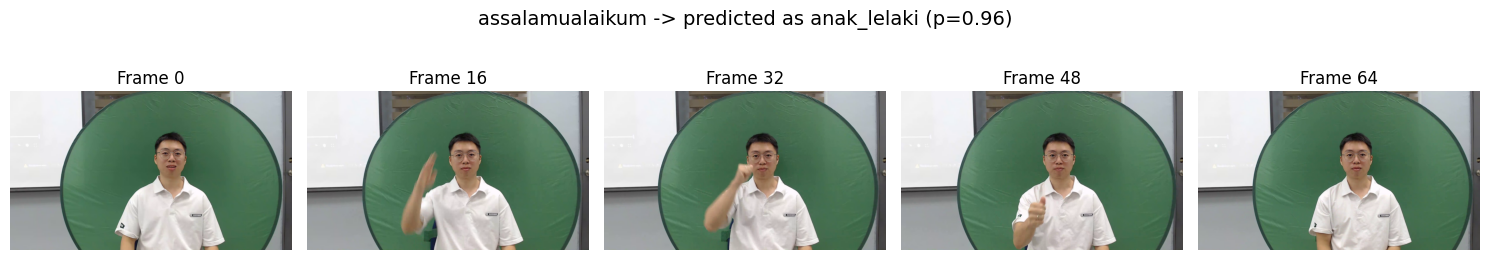

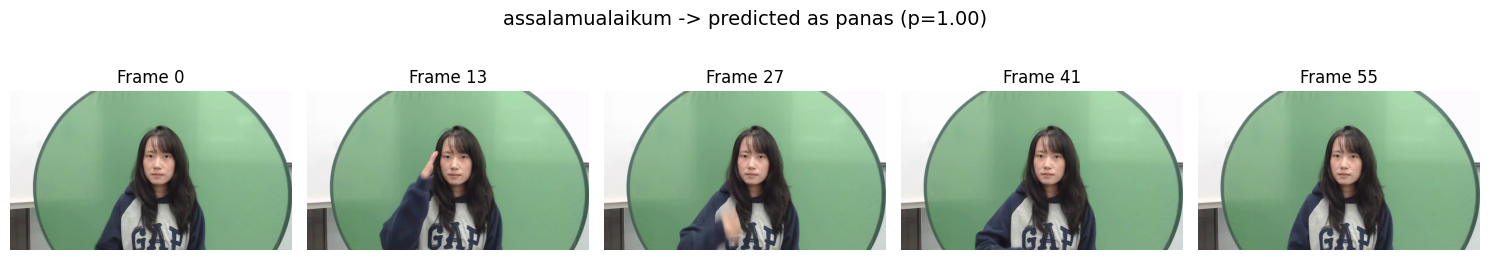

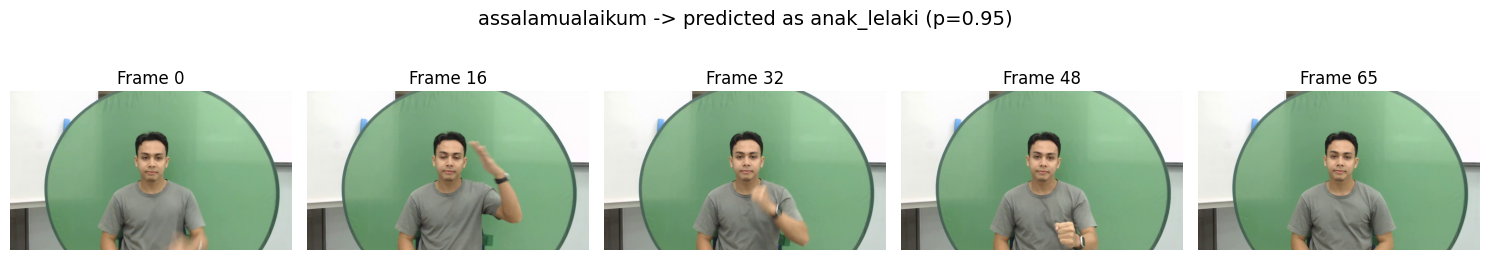

In [95]:
for vid_name, predicted_class, predicted_prob in wrong_predictions:
    video_path = DATA_DIR / "video/assalamualaikum" / f"{vid_name}.mp4"
    plot_video_frames(
        video_path,
        num_frames=5,
        title=f"assalamualaikum -> predicted as {idx_to_label[predicted_class]} (p={predicted_prob:.2f})",
    )

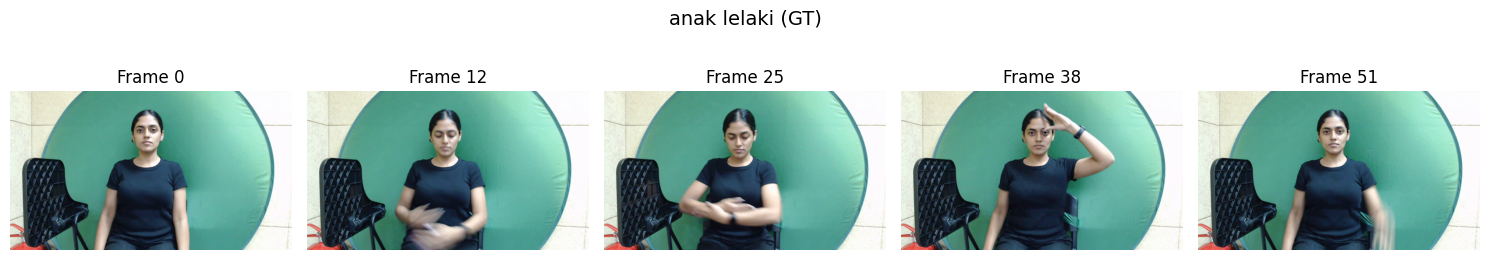

In [98]:
anak_lelaki_video_path = DATA_DIR / "video/anak_lelaki/anak lelaki_01_01_03.mp4"
plot_video_frames(
    video_path=anak_lelaki_video_path, num_frames=5, title="anak lelaki (GT)"
)

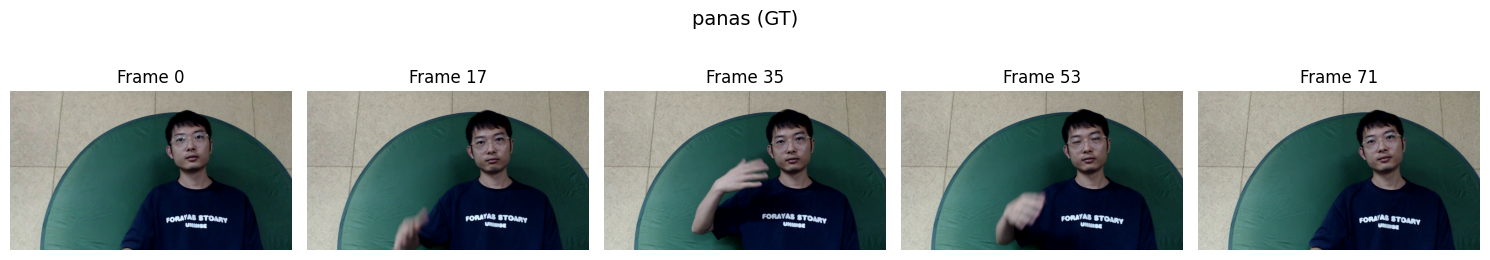

In [99]:
panas_video_path = DATA_DIR / "video/panas/hot_05_01_03.mp4"
plot_video_frames(video_path=panas_video_path, num_frames=5, title="panas (GT)")